In [1]:
import pandas as pd
import numpy as np
import math

df = pd.read_csv('./data.csv',encoding='shift_jis')
df.isnull().sum()
print(len(df.index))

4959


In [2]:
#ばらつきのスコア(標準偏差)を定義
df["standard deviation"] = ((df["平均評価"]-1)**2)*df["1点評価の割合"]+((df["平均評価"]-2)**2)*df["2点評価の割合"]+((df["平均評価"]-3)**2)*df["3点評価の割合"]+ ((df["平均評価"]-4)**2)*df["4点評価の割合"]+((df["平均評価"]-5)**2)*df["5点評価の割合"]
df["standard deviation"] = (df["standard deviation"])**0.5/10
#標準偏差でソート
sd_sorted = df.sort_values(by="standard deviation",ascending=False)
sd_sorted_top500 = sd_sorted[0:500]

#平均評価でソート
average_sorted = df.sort_values(by="平均評価",ascending=False)
average_sorted_top500 = average_sorted[0:500]

In [3]:
sd_sorted[["平均評価","5点評価の割合","4点評価の割合","3点評価の割合","2点評価の割合","1点評価の割合","standard deviation"]]

,平均評価,5点評価の割合,4点評価の割合,3点評価の割合,2点評価の割合,1点評価の割合,standard deviation
1167,2.64,33.7,6.0,4.2,2.5,53.6,1.856136
3178,2.70,33.8,7.7,3.2,5.6,49.7,1.839783
70,2.25,30.0,1.3,0.6,0.4,67.8,1.836181
664,2.33,30.0,2.8,1.4,1.5,64.3,1.833598
398,3.06,40.5,9.5,5.9,4.0,40.2,1.832835
...,...,...,...,...,...,...,...
3496,4.48,62.4,26.0,10.0,1.0,0.7,0.770682
1855,4.51,64.2,26.3,7.2,1.5,0.9,0.769480
820,4.46,60.0,28.8,9.3,1.2,0.7,0.768479
3430,4.14,30.4,57.4,10.4,0.0,1.9,0.747382


In [4]:
#どのようなジャンルがあるかを調べる
genres = []
for i in range(len(df.index)):
    genres.append(df.iloc[i]["ジャンル1"])
    genres.append(df.iloc[i]["ジャンル2"])
    genres.append(df.iloc[i]["ジャンル3"])
    genres.append(df.iloc[i]["ジャンル4"])
    
genres_all = pd.unique(genres)
genres_all = np.delete(genres_all,6)
# ['青春' 'SF' 'ファンタジー' 'アニメ' 'アクション' 'アドベンチャー' '特撮' 'ドラマ' '戦争' 'ロマンス' 'ミュージカル' 'コメディ' 'ホラー' 'サスペンス' 'ファミリー' 'ドキュメンタリー' '西部劇']

In [5]:
#データフレーム(df)の中に指定されたジャンル(genre)に属する映画が何本あるかカウント
def num_belong_to(df,genre):
    cnt = 0
    for i in range(len(df.index)):
        if ((df.iloc[i]["ジャンル1"]==genre)or(df.iloc[i]["ジャンル2"]==genre)or(df.iloc[i]["ジャンル3"]==genre)or(df.iloc[i]["ジャンル4"]==genre)):
            cnt = cnt + 1
            
    return cnt

In [6]:
#ジャンルについて分析するデータフレーム
#元のデータフレーム、標準偏差top500、平均評価top500について各ジャンルをカウントし、scaledで標準偏差top500、平均評価top500と全体との比をとっている
df_GenreAnalysis = pd.DataFrame(index=[],columns=genres_all)
index = ['original','sd_sorted500','average_sorted500']
dfs = [df,sd_sorted_top500,average_sorted_top500]
for i in range(3):
    tmp = []
    for j in df_GenreAnalysis.columns:
        tmp.append(num_belong_to(dfs[i],j))
        
    df_GenreAnalysis.loc[index[i]] = tmp

df_GenreAnalysis.loc['sd_scaled'] = (df_GenreAnalysis.loc['sd_sorted500']*len(df.index))/(df_GenreAnalysis.loc['original']*500)
df_GenreAnalysis.loc['average_scaled'] = (df_GenreAnalysis.loc['average_sorted500']*len(df.index))/(df_GenreAnalysis.loc['original']*500)
df_GenreAnalysis

,青春,SF,ファンタジー,アニメ,アクション,アドベンチャー,特撮,ドラマ,戦争,ロマンス,ミュージカル,コメディ,ホラー,サスペンス,ファミリー,ドキュメンタリー,西部劇
original,460,553,443,486,1180,534,50,2109,151,661,57,985,356,1136,224,42,28
sd_sorted500,112,60,49,125,116,60,22,148,18,112,4,84,28,55,30,7,0
average_sorted500,54,60,71,127,99,64,8,237,19,47,13,83,4,53,52,14,3
sd_scaled,2.414817,1.076094,1.097025,2.550926,0.97499,1.114382,4.36392,0.696,1.182278,1.680508,0.696,0.845799,0.780067,0.480185,1.328304,1.653,0.0
average_scaled,1.164287,1.076094,1.589567,2.591741,0.832103,1.188674,1.58688,1.114541,1.24796,0.705213,2.262,0.83573,0.111438,0.462724,2.302393,3.306,1.062643


In [7]:
#比率の差のZ検定を行う関数
def calcurate_Z(n_original,n_sorted):
    p1_hat = n_original/4949
    p2_hat = n_sorted/500
    p_hat = (4949*p1_hat+500*p2_hat)/(4949+500)
    return (p2_hat-p1_hat)/math.sqrt(p_hat*(1-p_hat)*((1/4949)+(1/500)))

In [8]:
#sd_Zの絶対値が1.96を超えたジャンルは好みの別れ具合に影響を及ぼすジャンルだと判定できる
#average_Zの絶対値が1.96を超えたジャンルは平均評価に影響を及ぼすジャンルだと判定できる
index_forZ = ['sd_Z','average_Z']
for i in range(2):
    tmp = []
    for j in df_GenreAnalysis.columns:
        tmp.append(calcurate_Z(df_GenreAnalysis.loc['original'][j],df_GenreAnalysis.loc[df_GenreAnalysis.index[i+1]][j]))
        
    df_GenreAnalysis.loc[index_forZ[i]] = tmp
    
df_GenreAnalysis

,青春,SF,ファンタジー,アニメ,アクション,アドベンチャー,特撮,ドラマ,戦争,ロマンス,ミュージカル,コメディ,ホラー,サスペンス,ファミリー,ドキュメンタリー,西部劇
original,460,553,443,486,1180,534,50,2109,151,661,57,985,356,1136,224,42,28
sd_sorted500,112,60,49,125,116,60,22,148,18,112,4,84,28,55,30,7,0
average_sorted500,54,60,71,127,99,64,8,237,19,47,13,83,4,53,52,14,3
sd_scaled,2.414817,1.076094,1.097025,2.550926,0.97499,1.114382,4.36392,0.696,1.182278,1.680508,0.696,0.845799,0.780067,0.480185,1.328304,1.653,0.0
average_scaled,1.164287,1.076094,1.589567,2.591741,0.832103,1.188674,1.58688,1.114541,1.24796,0.705213,2.262,0.83573,0.111438,0.462724,2.302393,3.306,1.062643
sd_Z,9.111107,0.557086,0.631048,10.252166,-0.321933,0.82733,6.32596,-5.630385,0.674711,5.523629,-0.712451,-1.665174,-1.326674,-6.163984,1.489844,1.2446,-1.686258
average_Z,1.097411,0.557086,3.826736,10.507311,-2.032938,1.370311,1.224562,2.059488,0.917938,-2.507451,2.740606,-1.773127,-5.484849,-6.374097,5.708184,4.123127,0.096983


In [9]:
#sdと各パラメータの相関係数
df_sd = df[["物語","配役","演出","映像","音楽","standard deviation"]]
df_sd.corr()

,物語,配役,演出,映像,音楽,standard deviation
物語,1.000000,0.823556,0.918726,0.742136,0.760610,-0.413466
配役,0.823556,1.000000,0.838077,0.665981,0.714854,-0.390594
演出,0.918726,0.838077,1.000000,0.861386,0.821535,-0.437610
映像,0.742136,0.665981,0.861386,1.000000,0.827467,-0.289456
音楽,0.760610,0.714854,0.821535,0.827467,1.000000,-0.208564
standard deviation,-0.413466,-0.390594,-0.437610,-0.289456,-0.208564,1.000000


In [10]:
#平均評価と各パラメータの相関係数
df_average = df[["物語","配役","演出","映像","音楽","平均評価"]]
df_average.corr()

,物語,配役,演出,映像,音楽,平均評価
物語,1.000000,0.823556,0.918726,0.742136,0.760610,0.842778
配役,0.823556,1.000000,0.838077,0.665981,0.714854,0.764126
演出,0.918726,0.838077,1.000000,0.861386,0.821535,0.872000
映像,0.742136,0.665981,0.861386,1.000000,0.827467,0.777391
音楽,0.760610,0.714854,0.821535,0.827467,1.000000,0.766233
平均評価,0.842778,0.764126,0.872000,0.777391,0.766233,1.000000


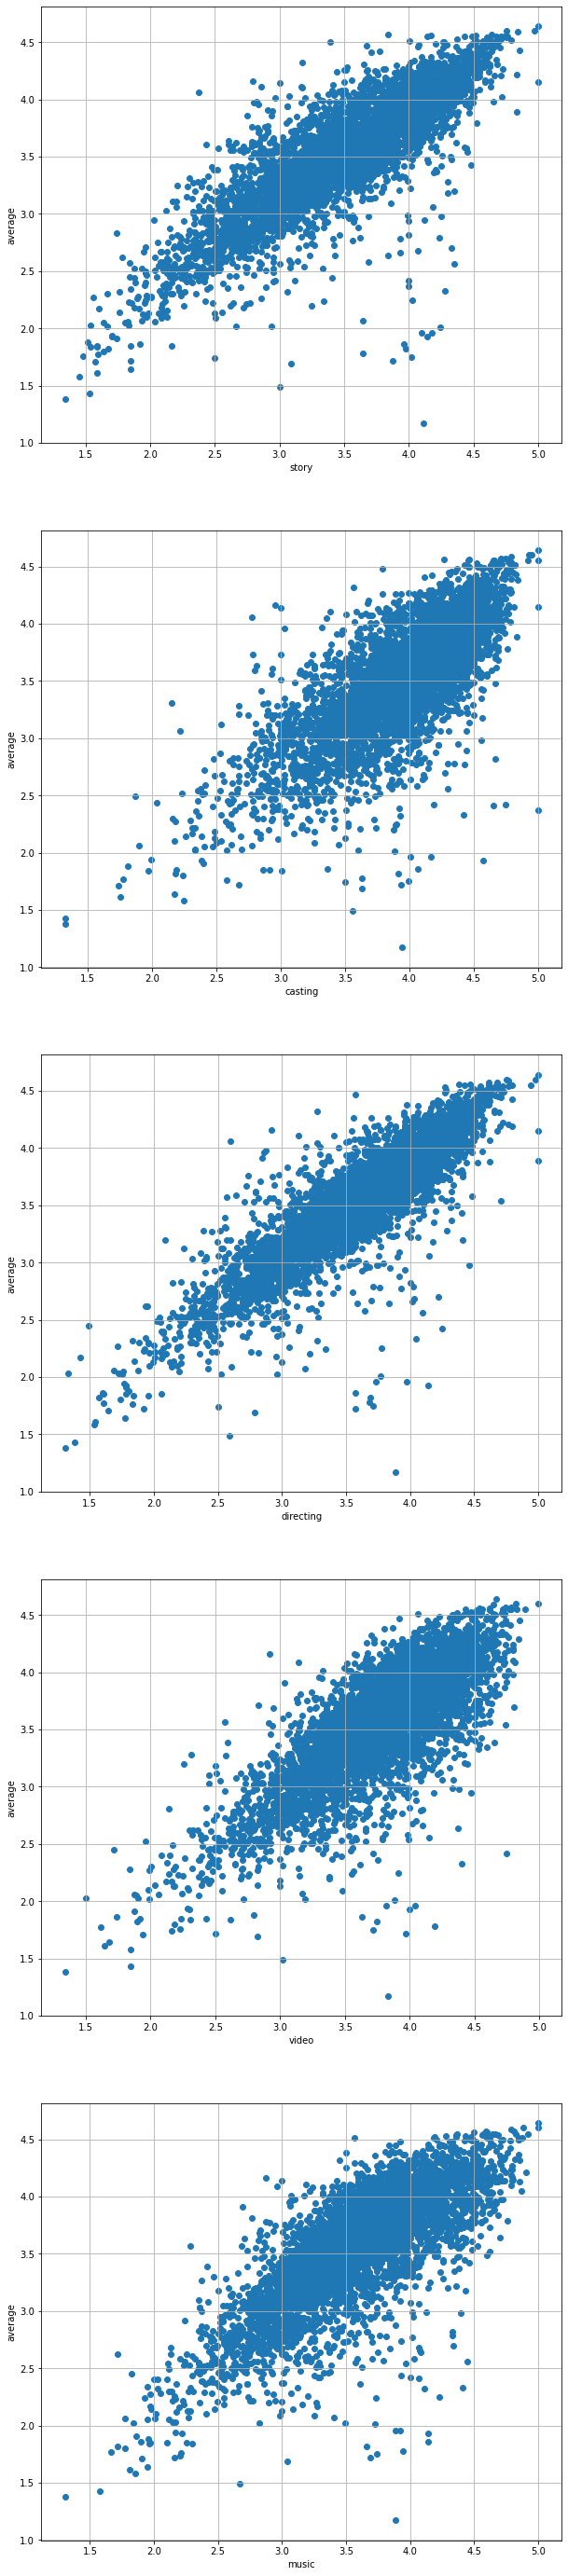

In [11]:
#平均評価と各パラメータの散布図
%matplotlib inline
import matplotlib.pyplot as plt

fig,axes = plt.subplots(5,1,figsize=(10,50))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

axes[0].scatter(df["物語"],df["平均評価"])
axes[0].set_xlabel("story")
axes[0].set_ylabel("average")
axes[0].grid(True)

axes[1].scatter(df["配役"],df["平均評価"])
axes[1].set_xlabel("casting")
axes[1].set_ylabel("average")
axes[1].grid(True)

axes[2].scatter(df["演出"],df["平均評価"])
axes[2].set_xlabel("directing")
axes[2].set_ylabel("average")
axes[2].grid(True)

axes[3].scatter(df["映像"],df["平均評価"])
axes[3].set_xlabel("video")
axes[3].set_ylabel("average")
axes[3].grid(True)

axes[4].scatter(df["音楽"],df["平均評価"])
axes[4].set_xlabel("music")
axes[4].set_ylabel("average")
axes[4].grid(True)

plt.show()

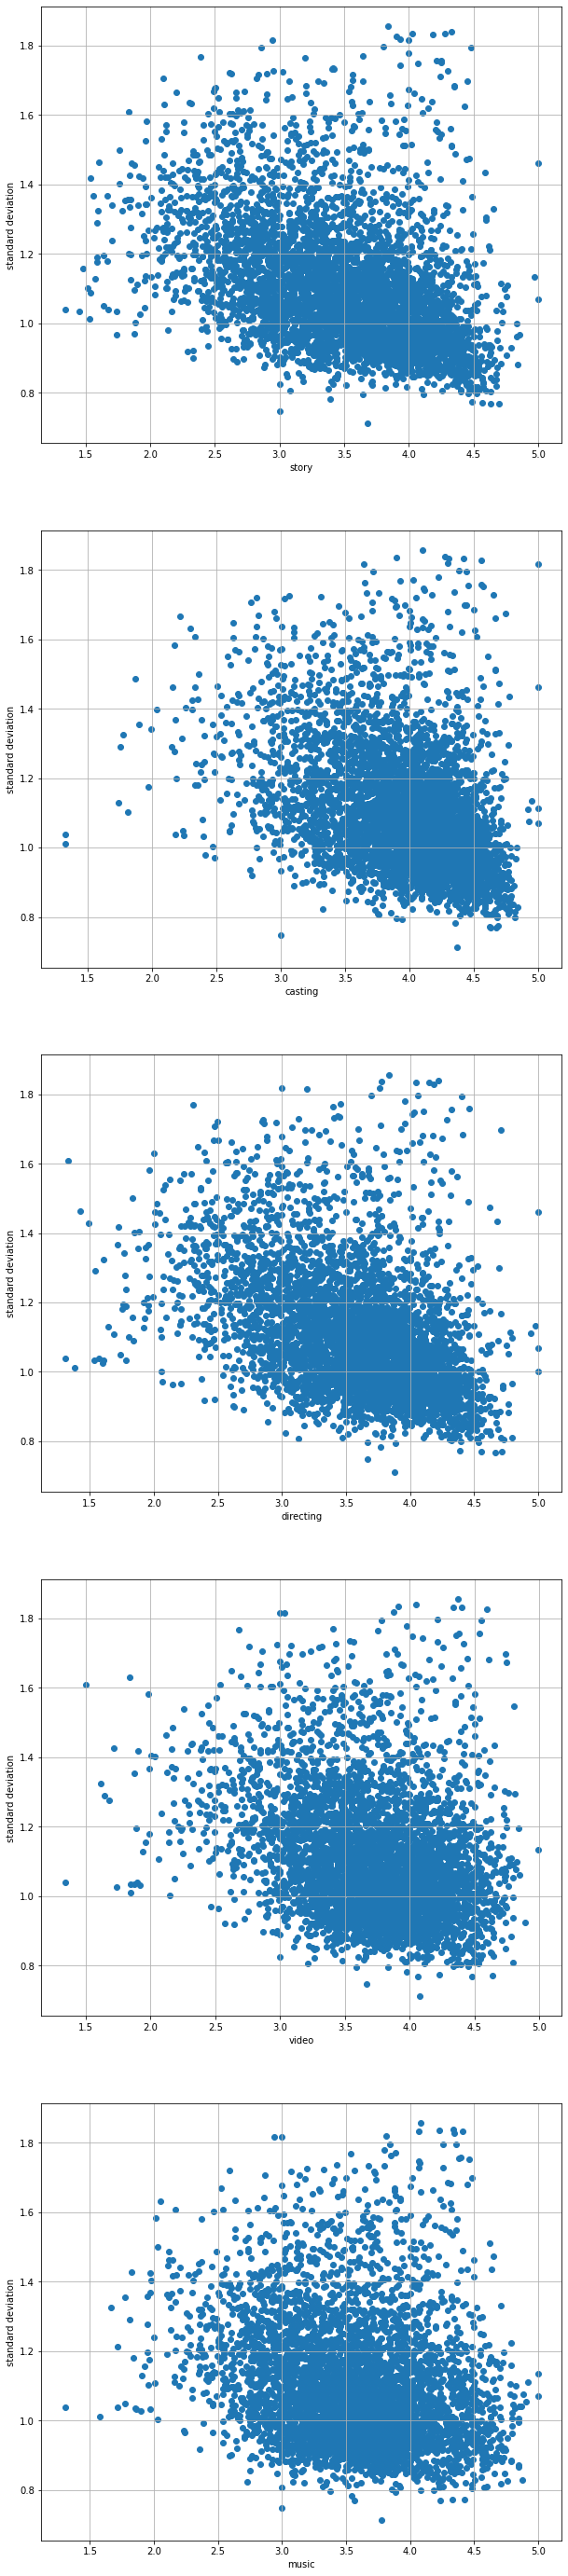

In [12]:
#標準偏差と各パラメータの散布図
%matplotlib inline
import matplotlib.pyplot as plt

fig,axes = plt.subplots(5,1,figsize=(10,50))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

axes[0].scatter(df["物語"],df["standard deviation"])
axes[0].set_xlabel("story")
axes[0].set_ylabel("standard deviation")
axes[0].grid(True)

axes[1].scatter(df["配役"],df["standard deviation"])
axes[1].set_xlabel("casting")
axes[1].set_ylabel("standard deviation")
axes[1].grid(True)

axes[2].scatter(df["演出"],df["standard deviation"])
axes[2].set_xlabel("directing")
axes[2].set_ylabel("standard deviation")
axes[2].grid(True)

axes[3].scatter(df["映像"],df["standard deviation"])
axes[3].set_xlabel("video")
axes[3].set_ylabel("standard deviation")
axes[3].grid(True)

axes[4].scatter(df["音楽"],df["standard deviation"])
axes[4].set_xlabel("music")
axes[4].set_ylabel("standard deviation")
axes[4].grid(True)

plt.show()